# Layer visualization using activation maximization
Now you will test a different way of visualizing what the network is computing. We will use a strategy analogous to what we did to generate adversarial images, only this time we will follow the gradient to maximize the activation of a particular set of nodes.

In [1]:
import numpy as np
import tensorflow as tf
#from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import os


# Step 1: Read in data


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
datadir='MNIST_data'
mnist = input_data.read_data_sets(datadir, one_hot=True, reshape=False)

#get MNIST test set
X_test = mnist.test.images
Y_test = mnist.test.labels


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
Y_test.shape #confirm Y is in one-hot format


(10000, 10)

In [4]:
#check the shape of the input images: is it 2-D or vectorized (1-D)?
img_shape = X_test.shape[1:3]
print(img_shape)

(28, 28)


# Step 2: Load model
Loading a pre-learned model in tensorflow is simple. We need to first load the meta data which is the computation graph. Then, load the weights. Why do we need `tf.Session()` to load a model? Remember that the model variables have no value without the session!

In [5]:
sess = tf.Session()
# load the computation graph
saver = tf.train.import_meta_graph('MNIST_model/model_Q3.meta')
# load the weights
saver.restore(sess, 'MNIST_model/model_Q3')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from MNIST_model/model_Q3


In [6]:
#load the variables from the pre-trained model so we can use them
graph = tf.get_default_graph()
x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y:0')
logits = graph.get_tensor_by_name('fc_1/logits:0')
probs = graph.get_tensor_by_name('probs:0')
cross_entropy = graph.get_tensor_by_name('cross_entropy:0')
accuracy = graph.get_tensor_by_name('accuracy:0')
preds_label = graph.get_tensor_by_name('preds_label:0')

# Step 3: Maximally-activating images

In [7]:

# Get a list of names for the operations in the graph
# in our pre-trained model where the operator-type is 'Conv2D'.
convnames = [op.name for op in graph.get_operations() if op.type=='Conv2D']
print(convnames)

#These are the conv layers available for visualization
# (Observe that sometimes there might be duplicates -- just ignore them...)

['conv_1/Conv2D', 'conv_2/Conv2D', 'conv_3/Conv2D']


In [8]:
# This is a function for finding a maximally-activating image using gradient ascent

def generate_max_activ_images(conv_name, filter_idxs, num_iterations=30):
    '''returns a list of generated max images, one for each filter index provided'''
    
    # Get a reference to the tensor that is output by the
    # operator. Note that a ":0" must be added to the name for this.
    tensor = graph.get_tensor_by_name(conv_name + ":0")
    
    gen_imgs = [] #list to hold the imgs that will be returned
    
    for filter_idx in filter_idxs:
        print("Filter index:",filter_idx, end=" . ")

        # Our loss function will be the average of all the
        # tensor values (convolution at each position) for the given filter/feature.
        # This is the standard practice to ensure that we
        # get a full image, but feel free to experiment with
        # other strategies for the loss.
        loss = tf.reduce_mean(tensor[:,:,:,filter_idx])

        # Get the gradient for the loss-function w.r.t.
        # the input image. This creates a mathematical
        # function for calculating the gradient.
        gradient = tf.gradients(loss, x)

        # Generate a random image of the same size as the raw input.
        # Each pixel is a small random value between 0.45 and 0.55,
        # which is the middle of the valid range between 0 and 1.
        # This will be our starting point for the optimization,
        # or in other words our "initial guess". 
        image = 0.1 * np.random.uniform(size=img_shape) + 0.45

        # Perform a number of optimization iterations to find
        # the image that maximizes the loss-function.
        for i in range(num_iterations):

            # Reshape the array so it is a 4-rank tensor.
            img_reshaped = image[None,:,:,None]

            # Create a feed-dict for inputting the image to the graph.
            feed_dict = {x: img_reshaped}

            # Calculate the predicted class-scores,
            # as well as the gradient and the loss-value.
            pred, grad, loss_value = sess.run([preds_label, gradient, loss],
                                                 feed_dict=feed_dict)
            

            # Squeeze the dimensionality for the gradient-array.
            grad = np.array(grad).squeeze()

            # The gradient now tells us how much we need to change the
            # input image in order to maximize the given feature.

            # Calculate the step-size for updating the image.
            # Using a step-size if 1/std(grad) empirically helps for fast convergence.
            # (the addition of 1e-8 is to protect from div-by-zero)
            step_size = 1.0 / (grad.std() + 1e-8)

            # Update the image by adding the scaled gradient
            # This is called gradient ascent.
            image += step_size * grad

            # Ensure all pixel-values in the image are between 0 and 1.
            image = np.clip(image, 0.0, 1.0)

        # Squeeze the image to get rid of the extra unitary dims
        gen_imgs.append( image.squeeze() )
        print(" DONE. Loss:",loss_value)
    return gen_imgs

In [9]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Filter index: 5 .  DONE. Loss: 0.44068557


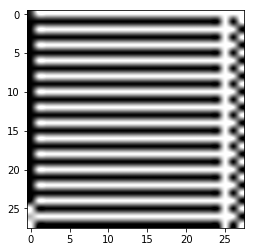

In [10]:
# Let's use the function above (make sure you understand what it's doing!)
# to generate a maximally-activating image for filter 5 in conv_1

#choose a conv layer operation and refer to it by its name
conv_name = 'conv_1/Conv2D'
#list of indices of filters in the conv layer for which to generate the max imgs
filter_list = [5]

ims = generate_max_activ_images(conv_name, filter_list)

#then plot it
plt.imshow(ims[0],cmap='gray',interpolation = 'spline16')

__Q. Now repeat the above for several filters in conv_1 and plot them in a subplot grid.__

Filter index: 3 .  DONE. Loss: 0.45078516
Filter index: 5 .  DONE. Loss: 0.4406853
Filter index: 4 .  DONE. Loss: 0.12596762
Filter index: 5 .  DONE. Loss: 0.44068566
Filter index: 1 .  DONE. Loss: 0.35725713
Filter index: 3 .  DONE. Loss: 0.45078337
Filter index: 5 .  DONE. Loss: 0.44068563


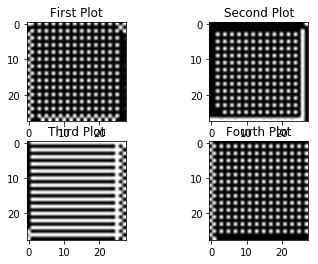

In [11]:
# YOUR CODE HERE
# Let's use the function above (make sure you understand what it's doing!)
# to generate a maximally-activating image for filter 5 in conv_1

#choose a conv layer operation and refer to it by its name
conv_name = 'conv_1/Conv2D'
#list of indices of filters in the conv layer for which to generate the max imgs
filter_list = [3,5]
filter_list2 = [4]
filter_list3 = [5]
filter_list4 = [1,3,5]

ims = generate_max_activ_images(conv_name, filter_list)
ims2 = generate_max_activ_images(conv_name, filter_list2)
ims3 = generate_max_activ_images(conv_name, filter_list3)
ims4 = generate_max_activ_images(conv_name, filter_list4)


#then plot it
# plt.imshow(ims[0],cmap='gray',interpolation = 'spline16')

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.title.set_text('First Plot')
ax1.imshow(ims[0],cmap='gray',interpolation = 'spline16')
ax2.title.set_text('Second Plot')
ax2.imshow(ims2[0],cmap='gray',interpolation = 'spline16')
ax3.title.set_text('Third Plot')
ax3.imshow(ims3[0],cmap='gray',interpolation = 'spline16')
ax4.title.set_text('Fourth Plot')
ax4.imshow(ims4[0],cmap='gray',interpolation = 'spline16')
plt.show()

__Q. Do the same for conv_2 and conv_3. Do you notice any difference in the complexity of the images obtained for different layers?__

Filter index: 6 .  DONE. Loss: 0.37637433
Filter index: 7 .  DONE. Loss: -0.15334626
Filter index: 4 .  DONE. Loss: 0.2449675
Filter index: 5 .  DONE. Loss: 0.1617852
Filter index: 1 .  DONE. Loss: 0.77773416
Filter index: 3 .  DONE. Loss: -0.6640748
Filter index: 5 .  DONE. Loss: 0.1255459


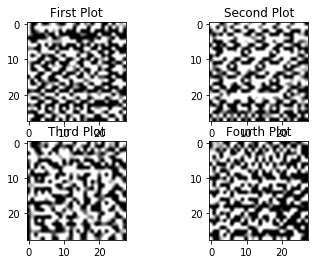

In [12]:
# YOUR CODE HERE
#choose a conv layer operation and refer to it by its name
conv_name = 'conv_2/Conv2D'
#list of indices of filters in the conv layer for which to generate the max imgs
filter_list = [6,7]
filter_list2 = [4]
filter_list3 = [5]
filter_list4 = [1,3,5]

ims = generate_max_activ_images(conv_name, filter_list)
ims2 = generate_max_activ_images(conv_name, filter_list2)
ims3 = generate_max_activ_images(conv_name, filter_list3)
ims4 = generate_max_activ_images(conv_name, filter_list4)


#then plot it
# plt.imshow(ims[0],cmap='gray',interpolation = 'spline16')

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.title.set_text('First Plot')
ax1.imshow(ims[0],cmap='gray',interpolation = 'spline16')
ax2.title.set_text('Second Plot')
ax2.imshow(ims2[0],cmap='gray',interpolation = 'spline16')
ax3.title.set_text('Third Plot')
ax3.imshow(ims3[0],cmap='gray',interpolation = 'spline16')
ax4.title.set_text('Fourth Plot')
ax4.imshow(ims4[0],cmap='gray',interpolation = 'spline16')
plt.show()


__Q. Think about possible modifications to the scheme used above for optimizing the images. Do you agree with the chosen loss function? Is our initial guess a reasonable one?__

Our initial guess was a reasonable one. One possible modification is to scale the original loss function with a certain lambda, which helps speed up the process in the training. 

# Step 3: Maximizing the final output layer

We can apply the same strategy to maximize the value of each node in the fully-connected layers as well. in fact, we can go all the way and find an image that maximizes the final classification output of our network!

__Q. Modify the__ `generate_max_activ_images` __function so that if the__ `conv_name` __is__ `None` __it will compute the loss using__ `probs[:,filter_idx]` __instead (where filter_idx will be used as the class index to optimize for).__

In [13]:
# YOUR CODE HERE
def generate_max_activ_images(conv_name, filter_idxs, num_iterations=30):
    '''returns a list of generated max images, one for each filter index provided'''
    
    # Get a reference to the tensor that is output by the
    # operator. Note that a ":0" must be added to the name for this.
    tensor = graph.get_tensor_by_name(conv_name + ":0")
    
    gen_imgs = [] #list to hold the imgs that will be returned
    
    
    if conv_name == None:
        
         for filter_idx in filter_idxs:
            print("Filter index:",filter_idx, end=" . ")

            # Our loss function will be the average of all the
            # tensor values (convolution at each position) for the given filter/feature.
            # This is the standard practice to ensure that we
            # get a full image, but feel free to experiment with
            # other strategies for the loss.
#             loss = tf.reduce_mean(tensor[:,:,:,filter_idx])
            loss = probs[:,filter_idx]

            # Get the gradient for the loss-function w.r.t.
            # the input image. This creates a mathematical
            # function for calculating the gradient.
            gradient = tf.gradients(loss, x)

            # Generate a random image of the same size as the raw input.
            # Each pixel is a small random value between 0.45 and 0.55,
            # which is the middle of the valid range between 0 and 1.
            # This will be our starting point for the optimization,
            # or in other words our "initial guess". 
            image = 0.1 * np.random.uniform(size=img_shape) + 0.45

            # Perform a number of optimization iterations to find
            # the image that maximizes the loss-function.
            for i in range(num_iterations):

                # Reshape the array so it is a 4-rank tensor.
                img_reshaped = image[None,:,:,None]

                # Create a feed-dict for inputting the image to the graph.
                feed_dict = {x: img_reshaped}

                # Calculate the predicted class-scores,
                # as well as the gradient and the loss-value.
                pred, grad, loss_value = sess.run([preds_label, gradient, loss],
                                                     feed_dict=feed_dict)


                # Squeeze the dimensionality for the gradient-array.
                grad = np.array(grad).squeeze()

                # The gradient now tells us how much we need to change the
                # input image in order to maximize the given feature.

                # Calculate the step-size for updating the image.
                # Using a step-size if 1/std(grad) empirically helps for fast convergence.
                # (the addition of 1e-8 is to protect from div-by-zero)
                step_size = 1.0 / (grad.std() + 1e-8)

                # Update the image by adding the scaled gradient
                # This is called gradient ascent.
                image += step_size * grad

                # Ensure all pixel-values in the image are between 0 and 1.
                image = np.clip(image, 0.0, 1.0)

            # Squeeze the image to get rid of the extra unitary dims
            gen_imgs.append( image.squeeze() )
            print(" DONE. Loss:",loss_value)
            
            
  
    
    
    
    else: 
        for filter_idx in filter_idxs:
            print("Filter index:",filter_idx, end=" . ")

            # Our loss function will be the average of all the
            # tensor values (convolution at each position) for the given filter/feature.
            # This is the standard practice to ensure that we
            # get a full image, but feel free to experiment with
            # other strategies for the loss.
            loss = tf.reduce_mean(tensor[:,:,:,filter_idx])

            # Get the gradient for the loss-function w.r.t.
            # the input image. This creates a mathematical
            # function for calculating the gradient.
            gradient = tf.gradients(loss, x)

            # Generate a random image of the same size as the raw input.
            # Each pixel is a small random value between 0.45 and 0.55,
            # which is the middle of the valid range between 0 and 1.
            # This will be our starting point for the optimization,
            # or in other words our "initial guess". 
            image = 0.1 * np.random.uniform(size=img_shape) + 0.45

            # Perform a number of optimization iterations to find
            # the image that maximizes the loss-function.
            for i in range(num_iterations):

                # Reshape the array so it is a 4-rank tensor.
                img_reshaped = image[None,:,:,None]

                # Create a feed-dict for inputting the image to the graph.
                feed_dict = {x: img_reshaped}

                # Calculate the predicted class-scores,
                # as well as the gradient and the loss-value.
                pred, grad, loss_value = sess.run([preds_label, gradient, loss],
                                                     feed_dict=feed_dict)


                # Squeeze the dimensionality for the gradient-array.
                grad = np.array(grad).squeeze()

                # The gradient now tells us how much we need to change the
                # input image in order to maximize the given feature.

                # Calculate the step-size for updating the image.
                # Using a step-size if 1/std(grad) empirically helps for fast convergence.
                # (the addition of 1e-8 is to protect from div-by-zero)
                step_size = 1.0 / (grad.std() + 1e-8)

                # Update the image by adding the scaled gradient
                # This is called gradient ascent.
                image += step_size * grad

                # Ensure all pixel-values in the image are between 0 and 1.
                image = np.clip(image, 0.0, 1.0)

            # Squeeze the image to get rid of the extra unitary dims
            gen_imgs.append( image.squeeze() )
            print(" DONE. Loss:",loss_value)
    return gen_imgs

__Q. Now use your modified function to find one max image for each class. Plot the images that were found. These are images that the network finds to be the most accurate examples of each handwritten digit. Do you agree?__

Filter index: 6 .  DONE. Loss: 0.42834163
Filter index: 7 .  DONE. Loss: -0.06414792
Filter index: 4 .  DONE. Loss: 0.18525665
Filter index: 5 .  DONE. Loss: 0.12693013
Filter index: 1 .  DONE. Loss: 0.79359406
Filter index: 3 .  DONE. Loss: -0.70812935
Filter index: 5 .  DONE. Loss: 0.19213372


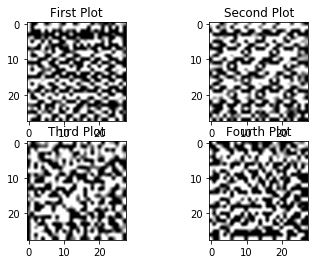

In [14]:
# YOUR CODE HERE
#choose a conv layer operation and refer to it by its name
conv_name = 'conv_2/Conv2D'
#list of indices of filters in the conv layer for which to generate the max imgs
filter_list = [6,7]
filter_list2 = [4]
filter_list3 = [5]
filter_list4 = [1,3,5]

ims = generate_max_activ_images(conv_name, filter_list)
ims2 = generate_max_activ_images(conv_name, filter_list2)
ims3 = generate_max_activ_images(conv_name, filter_list3)
ims4 = generate_max_activ_images(conv_name, filter_list4)


#then plot it
# plt.imshow(ims[0],cmap='gray',interpolation = 'spline16')

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.title.set_text('First Plot')
ax1.imshow(ims[0],cmap='gray',interpolation = 'spline16')
ax2.title.set_text('Second Plot')
ax2.imshow(ims2[0],cmap='gray',interpolation = 'spline16')
ax3.title.set_text('Third Plot')
ax3.imshow(ims3[0],cmap='gray',interpolation = 'spline16')
ax4.title.set_text('Fourth Plot')
ax4.imshow(ims4[0],cmap='gray',interpolation = 'spline16')
plt.show()



If you'd like to learn about more advanced visualization techniques, here are a few good lectures/tutorials:

https://www.youtube.com/watch?v=6wcs6szJWMY&t
    
https://www.youtube.com/watch?v=ghEmQSxT6tw

https://www.youtube.com/watch?v=AgkfIQ4IGaM